In [ ]:
!pip install --upgrade tqdm
import os 
os.kill(os.getpid(), 9)

     |████████████████████████████████| 71kB 6.6MB/s 
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


In [18]:
import sys
!{sys.executable} -m pip install tensorflow==1.15.0

  Using cached tensorflow-1.15.0-cp37-cp37m-macosx_10_11_x86_64.whl (124.0 MB)
  Using cached Keras_Applications-1.0.8-py3-none-any.whl (50 kB)
  Using cached tensorboard-1.15.0-py3-none-any.whl (3.8 MB)
  Using cached tensorflow_estimator-1.15.1-py2.py3-none-any.whl (503 kB)
Processing /Users/yeeeeehan/Library/Caches/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd/gast-0.2.2-cp37-none-any.whl
  Attempting uninstall: keras-applications
    Found existing installation: Keras-Applications 1.0.7
    Uninstalling Keras-Applications-1.0.7:
      Successfully uninstalled Keras-Applications-1.0.7
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0


In [22]:
# %tensorflow_version 1.x
import tensorflow as tf

print(tf.__version__)

2.3.1


In [27]:
!pwd
!ls

/Users/yeeeeehan/Library/Mobile Documents/com~apple~CloudDocs/Downloads/FYP3_1
Privacy-Preserving_notebook.ipynb     ffhq_dataset
__pycache__                           generated_images
align_images.py                       karras2019stylegan-ffhq-1024x1024.pkl
aligned_images                        latent_comparisons
comparison                            latent_generations
config.py                             latent_representations
data                                  masks
dnnlib                                raw_images
encode_images.py                      videos
encoder


# 1. Image pre-processing - Aligning images



#### In this section, we will :
*   Display all raw images
*   Align and rescale images to centralise the faces

In the alignment of the faces, the images is cropped to position the face in the middle of the image for consistency throughout all images.


<img src="https://raw.githubusercontent.com/YeeeeeHan/FYP/main/assets/aligning_images.png" height="300">




Found 1 images in raw_images
['stranger_7m.jpg']


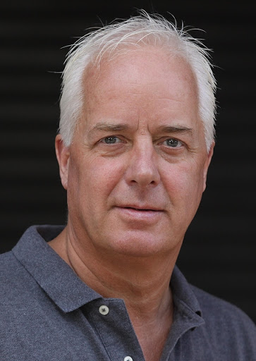

In [28]:
from PIL import Image
import os
imgs = sorted(os.listdir('raw_images'))
for index, img in enumerate(imgs):
    if img.find('.DS_Store') != -1:
        imgs.pop(index)

print("Found %d images in %s" %(len(imgs), 'raw_images'))
if len(imgs) == 0:
  print("Upload images to the \"raw_images\" folder!")
else:
  print(imgs)

for img_path in imgs:
  img = Image.open('raw_images/' + img_path)
  
  w,h = img.size
  rescale_ratio = 256 / min(w,h)
  img = img.resize((int(rescale_ratio*w),int(rescale_ratio*h)), Image.LANCZOS)
  display(img)

In [41]:
!python align_images.py raw_images aligned_images --output_size=1024

Using TensorFlow backend.
File path: aligned_images/stranger_7m.png
File already exists: False
Aligning stranger_7m.jpg ...
Getting landmarks...
Exception in landmark detection!


# 1.1 Displaying aligned images

In [31]:
def display_folder_content(folder, res = 256):
  if folder[-1] != '/': folder += '/'
  for i, img_path in enumerate(sorted(os.listdir(folder))):
    if '.png' in img_path:
      display(Image.open(folder+img_path).resize((res,res)), 'img %d: %s' %(i, img_path))
      print('\n')
      
display_folder_content('aligned_images')
print('done')


done


# 2. Encoding images

In [ ]:
!python encode_images.py --optimizer=lbfgs --lr=0.02 --decay_rate=0.95 --face_mask=True --iterations=4 \
 --use_lpips_loss=0 --use_discriminator_loss=0 --video_frame_rate=3 --output_video=True \
 aligned_images/ generated_images/ latent_representations/

In [ ]:
 import matplotlib.pyplot as plt
import matplotlib
from PIL import Image
import os

def plot_two_images(img1,img2, img_id, filename, fs = 12):
  f, axarr = plt.subplots(1,2, figsize=(fs,fs))
  axarr[0].imshow(img1)
  axarr[0].title.set_text('original')
  axarr[1].imshow(img2)
  axarr[1].title.set_text(filename)
  plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
  plt.tight_layout()
  plt.savefig("comparison/"+ filename +'.png')
  plt.show()

def display_sbs(folder1, folder2, res = 256):
  if folder1[-1] != '/': folder1 += '/'
  if folder2[-1] != '/': folder2 += '/'
    
  imgs1 = sorted([f for f in os.listdir(folder1) if '.png' in f])
  imgs2 = sorted([f for f in os.listdir(folder2) if '.png' in f])
  if len(imgs1)!=len(imgs2):
    print("Found different amount of images in aligned vs raw image directories. That's not supposed to happen...")
  
  for i in range(len(imgs1)):
    filename, _ = os.path.splitext(imgs2[i])
    img1 = Image.open(folder1+imgs1[i]).resize((res,res))
    img2 = Image.open(folder2+imgs2[i]).resize((res,res))
    plot_two_images(img1,img2, i, filename)
    print("")
     
display_sbs('aligned_images/','generated_images/', res = 512)

# 3. Viewing latents

In [ ]:
def generate_images(generator, latent_vector, z = True):
    batch_size = latent_vector.shape[0]
    

    if z: #Start from z: run the full generator network
        return generator.run(latent_vector.reshape((batch_size, 512)), None, randomize_noise=False, **synthesis_kwargs)
    else: #Start from w: skip the mapping network
        return generator.components.synthesis.run(latent_vector.reshape((batch_size, 18, 512)), randomize_noise=False, **synthesis_kwargs)


In [ ]:
 import matplotlib.pyplot as plt
import matplotlib
from PIL import Image
import os
import numpy as np
import dnnlib, pickle
import dnnlib.tflib as tflib
tflib.init_tf()
synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True), minibatch_size=1)

with open('karras2019stylegan-ffhq-1024x1024.pkl', 'rb') as f:
    generator_network, discriminator_network, averaged_generator_network = pickle.load(f)


def plot_two_images(img1,img2, img_id, filename, fs = 12):
  f, axarr = plt.subplots(1,2, figsize=(fs,fs))
  axarr[0].imshow(img1)
  axarr[0].title.set_text('original')
  axarr[1].imshow(img2)
  axarr[1].title.set_text(filename)
  plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
  plt.tight_layout()
  plt.savefig("latent_comparisons/"+ filename +'.png')
  plt.show()

def display_sbs(folder1, folder2, res = 256):
  if folder1[-1] != '/': folder1 += '/'
  if folder2[-1] != '/': folder2 += '/'
    
  imgs1 = sorted([f for f in os.listdir(folder1) if '.png' in f])
  imgs2 = sorted([f for f in os.listdir(folder2) if '.npy' in f])
  if len(imgs1)!=len(imgs2):
    print("Found different amount of images in aligned vs raw image directories. That's not supposed to happen...")
  
  for i in range(len(imgs1)):
    filename, _ = os.path.splitext(imgs1[i])
    img1 = Image.open(folder1+imgs1[i]).resize((res,res))
    print(folder2 + imgs2[i])
    print(type(img1))
    w = np.load(folder2 + imgs2[i]).reshape((1,18,-1))
    img2 = generate_images(averaged_generator_network, w, z = False)[0]
    img2 = Image.fromarray(img2.astype('uint8'), 'RGB')
    print(    os.path.join('latent_generations/', f'{filename}.png'))
    img2.save(os.path.join('latent_generations/', f'{filename}.png'), 'PNG')
    print(type(img2))
    img2 = img2.resize((res,res))

    plot_two_images(img1,img2, i, filename)
    print("")

  
display_sbs('aligned_images/','latent_representations/',res = 512)